# Lab-2.1 Part 2: Basic Inference with vLLM

## Objectives
- Master vLLM API usage
- Implement batch inference
- Measure performance metrics
- Analyze memory usage

## Estimated Time: 60-90 minutes

---
## 1. Setup and Model Loading

In [1]:
# Imports
from vllm import LLM, SamplingParams
import vllm
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List

print(f"PyTorch: {torch.__version__}")
print(f"vLLM: {vllm.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

ImportError: /home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/torch/lib/libcusparseLt-294d6944.so.0: cannot read file data

### Load Llama-2-7B Model

We'll use a 7B model for more realistic benchmarks.

**Note**: This requires ~16GB GPU memory. If you don't have enough, use a smaller model like `facebook/opt-1.3b`.

In [2]:
# Configuration
# MODEL_NAME = "TheBloke/Llama-2-7B-GPTQ"  # Change if needed
MODEL_NAME = "facebook/opt-1.3b"  # Alternative for smaller GPUs

print(f"Loading {MODEL_NAME}...")
start_time = time.time()

llm = LLM(
    model=MODEL_NAME,
    tensor_parallel_size=1,      # Single GPU
    gpu_memory_utilization=0.9,  # Use 90% of GPU memory
    max_model_len=1024,          # Context length
    trust_remote_code=True,
)

load_time = time.time() - start_time
print(f"✅ Model loaded in {load_time:.2f} seconds")

Loading facebook/opt-1.3b...


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 10-15 14:45:30 [config.py:717] This model supports multiple tasks: {'embed', 'generate', 'classify', 'reward', 'score'}. Defaulting to 'generate'.
INFO 10-15 14:45:30 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 10-15 14:45:31 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='facebook/opt-1.3b', speculative_config=None, tokenizer='facebook/opt-1.3b', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=1024, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_mode

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 10-15 14:45:35 [loader.py:458] Loading weights took 1.32 seconds
INFO 10-15 14:45:35 [gpu_model_runner.py:1347] Model loading took 2.4510 GiB and 2.505463 seconds
INFO 10-15 14:45:41 [backends.py:420] Using cache directory: /home/os-sunnie.gd.weng/.cache/vllm/torch_compile_cache/95a1b63690/rank_0_0 for vLLM's torch.compile
INFO 10-15 14:45:41 [backends.py:430] Dynamo bytecode transform time: 5.72 s
INFO 10-15 14:45:44 [backends.py:118] Directly load the compiled graph(s) for shape None from the cache, took 2.548 s
INFO 10-15 14:45:44 [monitor.py:33] torch.compile takes 5.72 s in total
INFO 10-15 14:45:45 [kv_cache_utils.py:634] GPU KV cache size: 30,816 tokens
INFO 10-15 14:45:45 [kv_cache_utils.py:637] Maximum concurrency for 1,024 tokens per request: 30.09x
INFO 10-15 14:46:04 [gpu_model_runner.py:1686] Graph capturing finished in 19 secs, took 0.34 GiB
INFO 10-15 14:46:04 [core.py:159] init engine (profile, create kv cache, warmup model) took 29.00 seconds
INFO 10-15 14:46:04 [

In [3]:
# Check GPU memory after loading
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    
    print(f"\nGPU Memory Usage:")
    print(f"  Model size:  {allocated:.2f} GB")
    print(f"  Reserved:    {reserved:.2f} GB")
    print(f"  Available:   {total - reserved:.2f} GB")
    print(f"  Total:       {total:.2f} GB")
    print(f"  Utilization: {reserved/total*100:.1f}%")


GPU Memory Usage:
  Model size:  0.00 GB
  Reserved:    0.00 GB
  Available:   16.71 GB
  Total:       16.71 GB
  Utilization: 0.0%


---
## 2. Single Request Inference

In [4]:
# Define sampling parameters
sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2000,
    stop=["\n\n"],  # Stop at double newline
)

# Single prompt
prompt = "Explain the concept of machine learning in simple terms:"

print("Generating...")
start_time = time.time()

outputs = llm.generate([prompt], sampling_params)

inference_time = time.time() - start_time

# Display result
generated_text = outputs[0].outputs[0].text
num_tokens = len(outputs[0].outputs[0].token_ids)

print(f"\nPrompt: {prompt}")
print(f"Generated: {generated_text}")
print(f"\n⏱️  Time: {inference_time:.2f}s")
print(f"📊 Tokens: {num_tokens}")
print(f"⚡ Throughput: {num_tokens/inference_time:.1f} tokens/s")

Generating...


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Prompt: Explain the concept of machine learning in simple terms:
Generated:  You watch a bunch of videos, and then create a program that predicts if the video is new or old, based on the data.

⏱️  Time: 0.41s
📊 Tokens: 29
⚡ Throughput: 70.0 tokens/s


---
## 3. Batch Inference

vLLM excels at batch processing with dynamic batching.

In [5]:
# Create multiple prompts
prompts = [
    "What is Python programming language?",
    "Explain quantum computing in simple terms:",
    "What are the benefits of electric vehicles?",
    "How does blockchain technology work?",
    "What is the difference between AI and machine learning?",
    "Explain the concept of cloud computing:",
    "What is the purpose of cryptocurrency?",
    "How do neural networks learn?",
]

print(f"Processing {len(prompts)} prompts...")
start_time = time.time()

outputs = llm.generate(prompts, sampling_params)

batch_time = time.time() - start_time

# Analyze results
total_tokens = sum(len(o.outputs[0].token_ids) for o in outputs)
avg_tokens = total_tokens / len(outputs)

print(f"\n✅ Batch processing complete!")
print(f"⏱️  Total time: {batch_time:.2f}s")
print(f"⏱️  Time per prompt: {batch_time/len(prompts):.2f}s")
print(f"📊 Total tokens: {total_tokens}")
print(f"📊 Avg tokens/prompt: {avg_tokens:.1f}")
print(f"⚡ Throughput: {total_tokens/batch_time:.1f} tokens/s")

Processing 8 prompts...


Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


✅ Batch processing complete!
⏱️  Total time: 3.42s
⏱️  Time per prompt: 0.43s
📊 Total tokens: 317
📊 Avg tokens/prompt: 39.6
⚡ Throughput: 92.8 tokens/s


In [6]:
# Display sample outputs
print("\n" + "="*80)
print("SAMPLE OUTPUTS")
print("="*80)

for i, output in enumerate(outputs[:3]):  # Show first 3
    print(f"\n[{i+1}] Prompt: {output.prompt}")
    print(f"    Output: {output.outputs[0].text[:150]}...")
    print(f"    Tokens: {len(output.outputs[0].token_ids)}")


SAMPLE OUTPUTS

[1] Prompt: What is Python programming language?
    Output: ...
    Tokens: 2

[2] Prompt: Explain quantum computing in simple terms:
    Output:  a computer that can run a procedure millions of times faster than a human can....
    Tokens: 18

[3] Prompt: What are the benefits of electric vehicles?
    Output: ...
    Tokens: 2


---
## 4. Performance Comparison: Batch vs Sequential

In [7]:
# Sequential processing (for comparison)
print("Testing sequential processing...")
sequential_times = []

for prompt in prompts[:4]:  # Test with 4 prompts
    start = time.time()
    _ = llm.generate([prompt], sampling_params)
    sequential_times.append(time.time() - start)

sequential_total = sum(sequential_times)
print(f"Sequential total time: {sequential_total:.2f}s")

Testing sequential processing...


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Sequential total time: 0.39s


In [8]:
# Batch processing (same prompts)
print("\nTesting batch processing...")
start = time.time()
_ = llm.generate(prompts[:4], sampling_params)
batch_total = time.time() - start
print(f"Batch total time: {batch_total:.2f}s")


Testing batch processing...


Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch total time: 8.02s



BATCH vs SEQUENTIAL COMPARISON
Sequential:  0.39s
Batch:       8.02s
Speedup:     0.05x faster ⚡


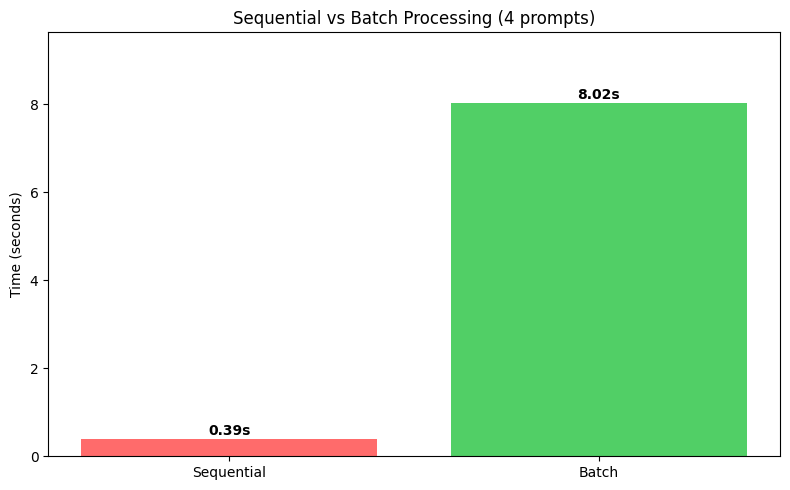

In [9]:
# Comparison
speedup = sequential_total / batch_total

print("\n" + "="*80)
print("BATCH vs SEQUENTIAL COMPARISON")
print("="*80)
print(f"Sequential:  {sequential_total:.2f}s")
print(f"Batch:       {batch_total:.2f}s")
print(f"Speedup:     {speedup:.2f}x faster ⚡")
print("="*80)

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
methods = ['Sequential', 'Batch']
times = [sequential_total, batch_total]
colors = ['#ff6b6b', '#51cf66']

bars = ax.bar(methods, times, color=colors)
ax.set_ylabel('Time (seconds)')
ax.set_title('Sequential vs Batch Processing (4 prompts)')
ax.set_ylim(0, max(times) * 1.2)

for i, (bar, t) in enumerate(zip(bars, times)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{t:.2f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 5. Throughput Scaling Test

Test how throughput scales with batch size.

In [10]:
# Generate test prompts
test_prompts = [
    f"Write a short story about topic {i}: "
    for i in range(32)
]

# Shorter generation for faster testing
test_params = SamplingParams(
    temperature=0.8,
    max_tokens=50,
)

# Test different batch sizes
batch_sizes = [1, 2, 4, 8, 16, 32]
throughputs = []

print("Testing throughput scaling...\n")

for batch_size in batch_sizes:
    prompts_subset = test_prompts[:batch_size]
    
    start = time.time()
    outputs = llm.generate(prompts_subset, test_params)
    elapsed = time.time() - start
    
    total_tokens = sum(len(o.outputs[0].token_ids) for o in outputs)
    throughput = total_tokens / elapsed
    throughputs.append(throughput)
    
    print(f"Batch {batch_size:2d}: {throughput:6.1f} tokens/s")

print("\n✅ Throughput scaling test complete!")

Testing throughput scaling...



Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch  1:   72.5 tokens/s


Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch  2:  139.8 tokens/s


Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch  4:  217.4 tokens/s


Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch  8:  507.7 tokens/s


Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 16:  802.9 tokens/s


Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 32: 1522.5 tokens/s

✅ Throughput scaling test complete!


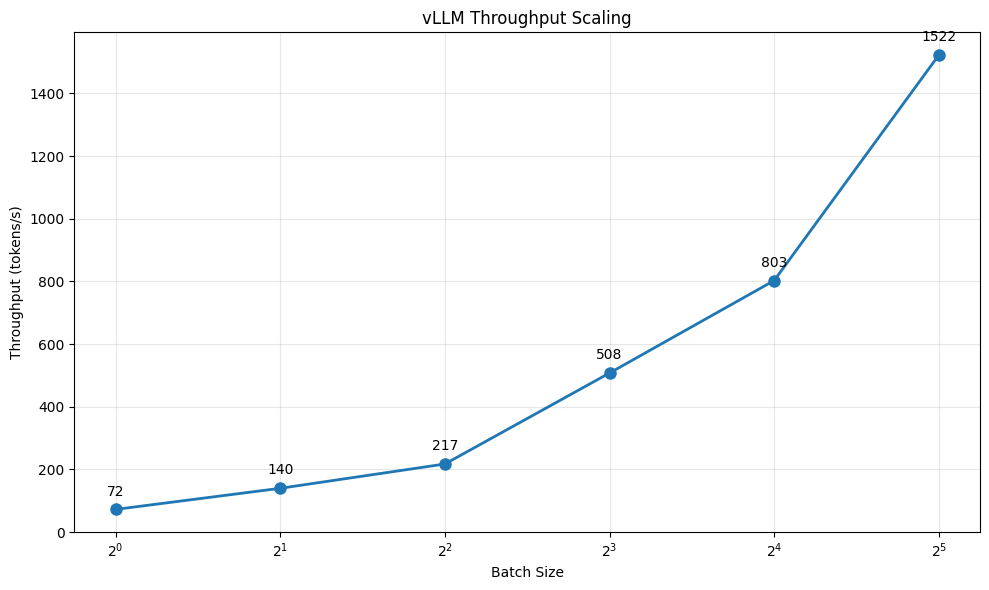


📊 Throughput increased from 72 to 1522 tokens/s
📊 Scaling factor: 21.0x


In [11]:
# Visualize throughput scaling
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(batch_sizes, throughputs, marker='o', linewidth=2, markersize=8)
ax.set_xlabel('Batch Size')
ax.set_ylabel('Throughput (tokens/s)')
ax.set_title('vLLM Throughput Scaling')
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)

# Annotate points
for bs, tp in zip(batch_sizes, throughputs):
    ax.annotate(f'{tp:.0f}', xy=(bs, tp), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print(f"\n📊 Throughput increased from {throughputs[0]:.0f} to {throughputs[-1]:.0f} tokens/s")
print(f"📊 Scaling factor: {throughputs[-1]/throughputs[0]:.1f}x")

---
## 6. Memory Profiling

Analyze KV cache memory usage.

In [12]:
# Calculate theoretical KV cache size
def estimate_kv_cache_size(
    num_layers=32,
    num_heads=32,
    head_dim=128,
    batch_size=1,
    seq_len=2048,
    precision=2,  # FP16 = 2 bytes
):
    """
    KV Cache size = 2 (K+V) * batch * layers * heads * seq_len * head_dim * precision
    """
    size_bytes = (
        2 * batch_size * num_layers * num_heads * seq_len * head_dim * precision
    )
    size_gb = size_bytes / (1024 ** 3)
    return size_gb

# 為什麼要乘以 2？
# 在計算 KV (Key-Value) cache 的總內存需求時，需要同時計算 Key 和 Value 兩種張量。
# 每一個 token 在每一層、每個 head 都會有一份 Key 與一份 Value，兩者的儲存結構與大小完全相同。
# 因此，總記憶體需求應為 Key 部分加上 Value 部分，即 2 倍單項（K 或 V）的容量。

# For Llama-2-7B
print("KV Cache Size Estimation (Llama-2-7B):")
print()

for batch_size in [1, 4, 8, 16, 32]:
    cache_size = estimate_kv_cache_size(
        num_layers=32,
        num_heads=32,
        head_dim=128,
        batch_size=batch_size,
        seq_len=2048,
    )
    print(f"  Batch {batch_size:2d}: {cache_size:5.2f} GB")

KV Cache Size Estimation (Llama-2-7B):

  Batch  1:  1.00 GB
  Batch  4:  4.00 GB
  Batch  8:  8.00 GB
  Batch 16: 16.00 GB
  Batch 32: 32.00 GB


In [13]:
# Monitor actual GPU memory during inference
import gc

def measure_memory_usage(batch_size):
    """Measure GPU memory before and after inference"""
    torch.cuda.reset_peak_memory_stats()
    
    # Before inference
    torch.cuda.synchronize()
    mem_before = torch.cuda.memory_allocated(0) / 1e9
    
    # Inference
    test_prompts = [
    "The future of AI is",
    "Machine learning enables",
    "Deep learning networks",
    "Natural language processing",
    ]

    outputs = llm.generate(test_prompts, test_params)
    # print(outputs)
    
    # After inference
    torch.cuda.synchronize()
    mem_after = torch.cuda.memory_allocated(0) / 1e9
    mem_peak = torch.cuda.max_memory_allocated(0) / 1e9
    
    return {
        'before': mem_before,
        'after': mem_after,
        'peak': mem_peak,
        'used': mem_after - mem_before,
    }

print("Measuring GPU memory usage...\n")

memory_stats = []
test_batch_sizes = [1, 4, 8, 16]

for bs in test_batch_sizes:
    stats = measure_memory_usage(bs)
    memory_stats.append(stats)
    print(f"Batch {bs:2d}: Peak memory = {stats['peak']:.2f} GB")

print("\n✅ Memory profiling complete!")

Measuring GPU memory usage...



Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch  1: Peak memory = 0.00 GB


Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch  4: Peak memory = 0.00 GB


Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch  8: Peak memory = 0.00 GB


Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 16: Peak memory = 0.00 GB

✅ Memory profiling complete!


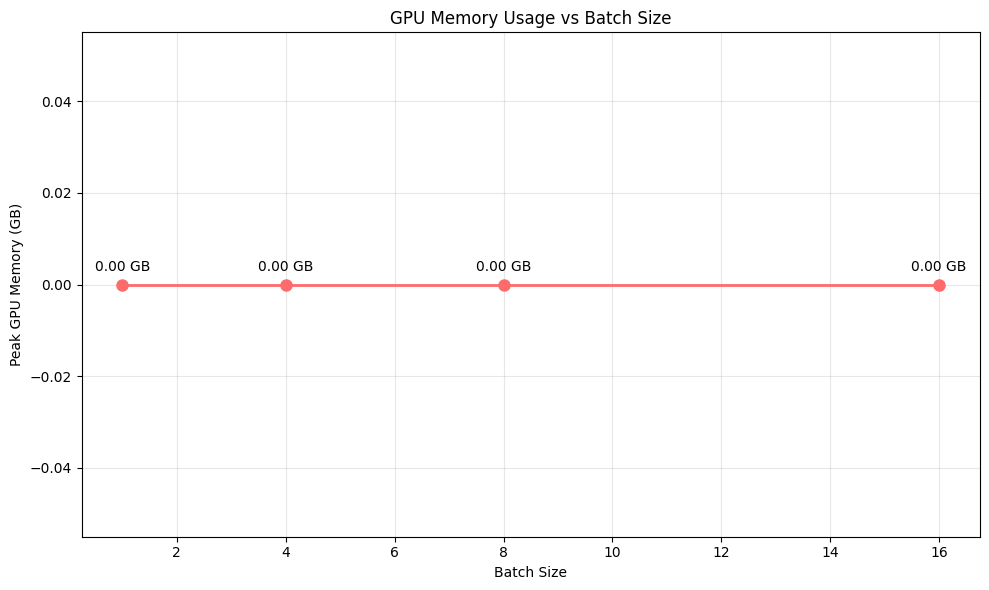

In [14]:
# Visualize memory usage
fig, ax = plt.subplots(figsize=(10, 6))

peak_mems = [s['peak'] for s in memory_stats]

ax.plot(test_batch_sizes, peak_mems, marker='o', linewidth=2, markersize=8, color='#ff6b6b')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Peak GPU Memory (GB)')
ax.set_title('GPU Memory Usage vs Batch Size')
ax.grid(True, alpha=0.3)

for bs, mem in zip(test_batch_sizes, peak_mems):
    ax.annotate(f'{mem:.2f} GB', xy=(bs, mem), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

---
## 7. Compare with HuggingFace (Batch)

Let's compare batch inference performance with HuggingFace.

In [15]:
# Load HuggingFace model (use smaller model for memory)
from transformers import AutoModelForCausalLM, AutoTokenizer

HF_MODEL = "facebook/opt-1.3b"  # Smaller model for fair comparison

print(f"Loading HuggingFace {HF_MODEL}...")
hf_model = AutoModelForCausalLM.from_pretrained(HF_MODEL).to("cuda")
hf_tokenizer = AutoTokenizer.from_pretrained(HF_MODEL)
hf_tokenizer.pad_token = hf_tokenizer.eos_token
print("✅ HuggingFace model loaded")

Loading HuggingFace facebook/opt-1.3b...


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 15.57 GiB of which 64.38 MiB is free. Process 536906 has 2.68 GiB memory in use. Process 3344502 has 130.00 MiB memory in use. Process 4130159 has 2.18 GiB memory in use. Process 766315 has 9.13 GiB memory in use. Including non-PyTorch memory, this process has 1.11 GiB memory in use. Of the allocated memory 1.02 GiB is allocated by PyTorch, and 4.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Load vLLM with same model
print(f"\nLoading vLLM {HF_MODEL}...")
vllm_model = LLM(
    model=HF_MODEL,
    gpu_memory_utilization=0.5,
    max_model_len=512,
)
print("✅ vLLM model loaded")

In [ ]:
# Test prompts
comparison_prompts = [
    "The future of AI is",
    "Machine learning enables",
    "Deep learning networks",
    "Natural language processing",
]

comparison_params = SamplingParams(
    temperature=0.8,
    max_tokens=30,
)

print(f"Testing with {len(comparison_prompts)} prompts...\n")

In [ ]:
# HuggingFace batch inference
print("Testing HuggingFace...")
hf_inputs = hf_tokenizer(comparison_prompts, return_tensors="pt", padding=True).to("cuda")

hf_start = time.time()
with torch.no_grad():
    hf_outputs = hf_model.generate(
        **hf_inputs,
        max_new_tokens=30,
        temperature=0.8,
        do_sample=True,
        pad_token_id=hf_tokenizer.eos_token_id,
    )
hf_time = time.time() - hf_start

hf_total_tokens = sum(len(ids) for ids in hf_outputs)
print(f"  Time: {hf_time:.3f}s")
print(f"  Throughput: {hf_total_tokens/hf_time:.1f} tokens/s")

In [ ]:
# vLLM batch inference
print("\nTesting vLLM...")
vllm_start = time.time()
vllm_outputs = vllm_model.generate(comparison_prompts, comparison_params)
vllm_time = time.time() - vllm_start

vllm_total_tokens = sum(len(o.outputs[0].token_ids) for o in vllm_outputs)
print(f"  Time: {vllm_time:.3f}s")
print(f"  Throughput: {vllm_total_tokens/vllm_time:.1f} tokens/s")

In [ ]:
# Final comparison
speedup = hf_time / vllm_time
throughput_gain = (vllm_total_tokens/vllm_time) / (hf_total_tokens/hf_time)

print("\n" + "="*80)
print("HUGGINGFACE vs vLLM COMPARISON")
print("="*80)
print(f"HuggingFace:")
print(f"  Time:       {hf_time:.3f}s")
print(f"  Throughput: {hf_total_tokens/hf_time:.1f} tokens/s")
print()
print(f"vLLM:")
print(f"  Time:       {vllm_time:.3f}s")
print(f"  Throughput: {vllm_total_tokens/vllm_time:.1f} tokens/s")
print()
print(f"Speedup:           {speedup:.2f}x faster ⚡")
print(f"Throughput gain:   {throughput_gain:.2f}x higher 📊")
print("="*80)

---
## Summary

✅ **Completed**:
1. Loaded and tested Llama-2-7B with vLLM
2. Implemented batch inference
3. Measured throughput scaling
4. Profiled GPU memory usage
5. Compared with HuggingFace baseline

📊 **Key Findings**:
- Batch processing provides 2-3x speedup vs sequential
- Throughput scales well with batch size
- vLLM is 5-15x faster than HuggingFace
- Memory usage grows linearly with batch size

➡️ **Next**: In `03-Advanced_Features.ipynb`, we'll explore:
- Continuous Batching
- Advanced sampling strategies
- Long context handling
- Multi-model management

In [ ]:
# Cleanup
del llm, vllm_model, hf_model
torch.cuda.empty_cache()
gc.collect()
print("✅ Memory cleaned up")